In [18]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from omegaconf import OmegaConf
from bachelors_thesis.modeling.sigloc import SigLoc12
from bachelors_thesis.modeling.datasets.sigloc_dataset import SigLocDataset
from bachelors_thesis.modeling.train import eval_loop
from bachelors_thesis.evaluation import set_level_accuracy, lead_level_accuracy
from bachelors_thesis.utils import plot_ecg
from bachelors_thesis.data.ptbxl_utility import get_ecg_signals_from_file
import wandb
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact("nateml-maastricht-university/bachelors-thesis/00_sigloc12_baseline_best:best")
artifact_path = artifact.download()

run = api.run("nateml-maastricht-university/bachelors-thesis/2ivqum26")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)

wandb:   1 of 1 files downloaded.  


In [13]:
cfg.model.feature_dim

64

In [14]:
# Load the model
checkpoint = torch.load(artifact_path + "/00_sigloc12_baseline_best.pth", map_location=torch.device('cuda'))

# Cast the model to the correct type
model = SigLoc12(cfg.model)
model.to("cuda")
model.load_state_dict(checkpoint)
model.eval()

SigLoc12(
  (local_encoder): LocalEncoder(
    (encoder): Sequential(
      (0): Conv1d(1, 16, kernel_size=(12,), stride=(1,), padding=(3,))
      (1): ReLU()
      (2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(1,))
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): ReLU()
      (8): AdaptiveAvgPool1d(output_size=1)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=128, out_features=64, bias=True)
      (11): ReLU()
    )
  )
  (context_encoder): DeepSetsContextEncoder(
    (phi): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
    )
    (rho): Sequential(
      (0): Linear(in_features=64, out_features=64, bias

In [2]:
# Load the validation data
val_data = np.load('../../data/processed/ptbxl100all/val.npy')

# Convert to tensor
val_data = torch.from_numpy(val_data).float()

# Reshape to (_, 6, 1000)
# val_data = val_data.view(-1, 6, 1000)
val_data = val_data.permute(0, 2, 1)
print(val_data.shape)

torch.Size([2183, 6, 1000])


In [16]:
# Create a dataloader for the validation data
dataset = SigLocDataset(val_data)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [17]:
model.eval()
logits = np.zeros((len(dataset), 6, 6))
for idx, batch in enumerate(dataloader):
    # Move the batch to the GPU
    batch = batch.to('cuda')

    if idx == 0:
        print(batch.shape)
    
    # Make predictions
    with torch.no_grad():
        _, these_logits = model(batch)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()

logits.shape

torch.Size([64, 6, 1000])


(2183, 6, 6)

In [5]:
targets = torch.arange(6, device=logits[0].device).expand(2183, -1)
targets.shape

NameError: name 'logits' is not defined

In [19]:
# Convert logits to tensor
logits = torch.from_numpy(logits).float()

In [20]:
# convert logits to probabilities
probs = torch.nn.functional.softmax(logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs[0])


[[100.     0.     0.     0.     0.     0.  ]
 [  0.01  77.78  22.1    0.1    0.01   0.  ]
 [  0.     1.88  96.82   1.29   0.01   0.  ]
 [  0.     0.25   0.4   97.87   1.46   0.01]
 [  0.     0.1    0.01   1.36  98.16   0.37]
 [  0.02   0.07   0.01   0.01   0.22  99.67]]


In [3]:
set_acc = set_level_accuracy(logits.cpu().numpy(), targets.cpu().numpy())
lead_acc = lead_level_accuracy(logits.cpu().numpy(), targets.cpu().numpy())
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

NameError: name 'logits' is not defined

In [23]:
# Find outliers

preds = np.argmax(logits.cpu().numpy(), axis=2)

# These are samples where the model predicted all 6 classes wrong 
outliers = np.where(np.all(preds != targets.cpu().numpy(), axis=1))[0]
print(preds[outliers][1])
print(len(outliers))

print("Probabilities:")
print(probs[outliers][1])

# These are samples where the model predicted all 6 classes right
correct = np.where(np.all(preds == targets.cpu().numpy(), axis=1))[0]

[5 2 1 2 3 0]
11
Probabilities:
[[ 7.38  0.31  0.02  0.63  5.19 86.48]
 [ 1.64 19.41 36.63 34.57  6.73  1.02]
 [ 1.21 40.25 39.49 14.86  3.84  0.35]
 [ 0.65 38.76 44.09 14.45  1.86  0.19]
 [19.99  8.24 15.05 46.08  8.82  1.82]
 [58.66  0.29  0.03  2.26 11.58 27.18]]


In [25]:
# I want to find all cases where the model predicted a lead more than 2 "positions" away from the correct lead
# E.g. if the model predicted 0, but the correct lead was 3, this is a distance of 3
wrongness_thresh = 3
wrong = np.where(np.abs(preds - targets.cpu().numpy()) > wrongness_thresh)[0]
print(len(wrong))

71


In [110]:
# Let's take a look at the metadata for these samples
metadata = np.load('../../data/processed/ptbxl100all/meta_val.npy', allow_pickle=True)
metadata = pd.DataFrame(metadata)
metadata.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,11275.0,48.0,0,NaN,95.0,2.0,0.0,CS-12 E,1984-12-01 14:49:52,sinusrhythmus linkstyp qrs(t) abnormal infe...,...,", II,AVF",", I-AVF,",NaN,NaN,NaN,NaN,9,records100/00000/00008_lr,records500/00000/00008_hr,[MI]
1,9456.0,22.0,1,NaN,56.0,2.0,0.0,CS-12 E,1984-12-12 14:12:46,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00010_lr,records500/00000/00010_hr,[NORM]
2,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 14:25:25,vorhof:hf 280 tachykardes vorhofflimmern uebe...,...,NaN,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00017_lr,records500/00000/00017_hr,[]
3,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 15:17:24,"vorhofflattern 2:1 Überleitung,jetzt nach isop...",...,NaN,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00018_lr,records500/00000/00018_hr,[]
4,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-23 12:55:32,supraventrikulÄre ersatzsystole(n) interponier...,...,NaN,NaN,NaN,NaN,VES,NaN,9,records100/00000/00020_lr,records500/00000/00020_hr,[]


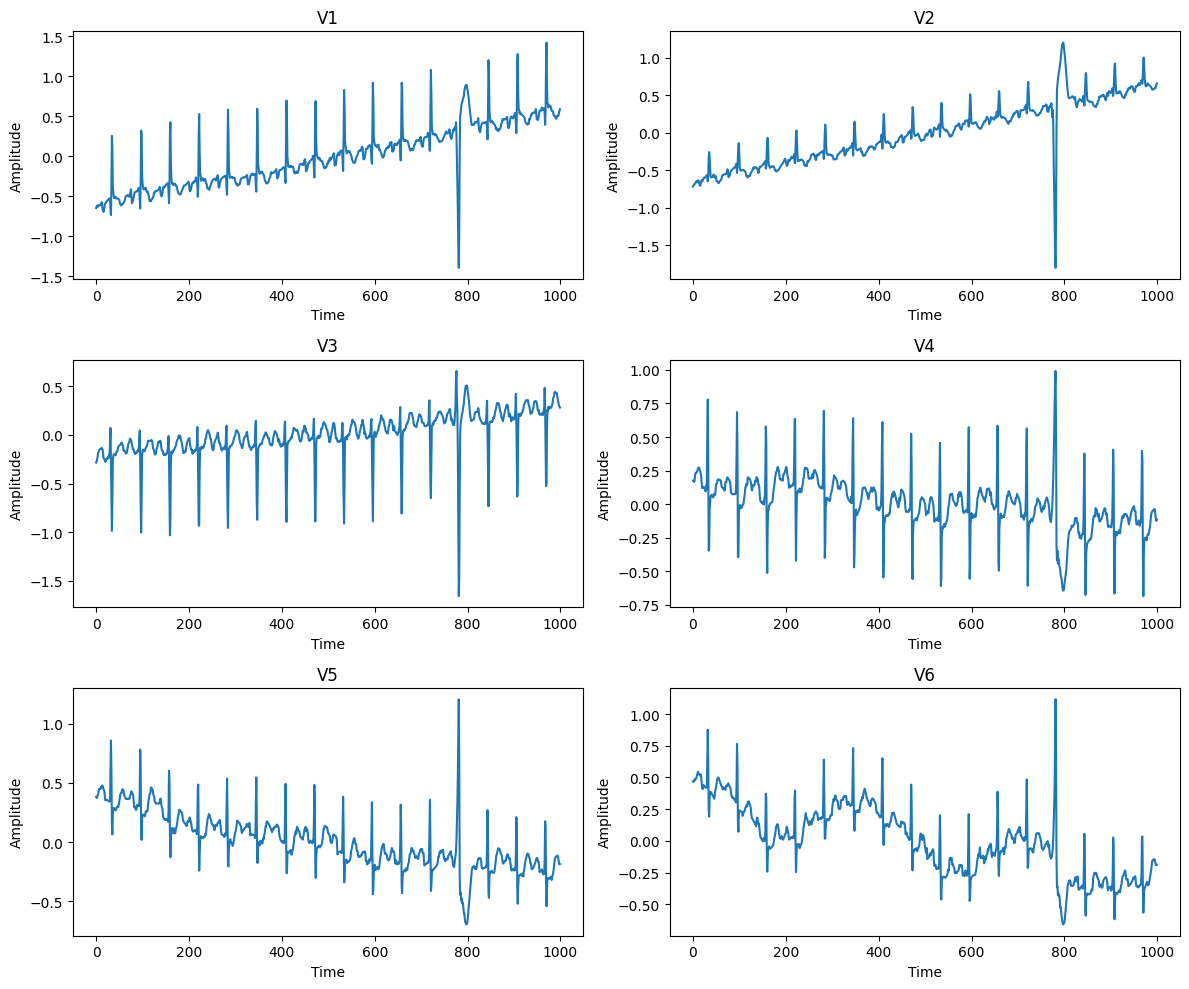

In [ ]:
# lets take a look at the signals from the first outlier
import matplotlib.pyplot as plt

signals = val_data[outliers[4]].cpu().numpy()

plot_signals(signals, time_cutoff=1000)

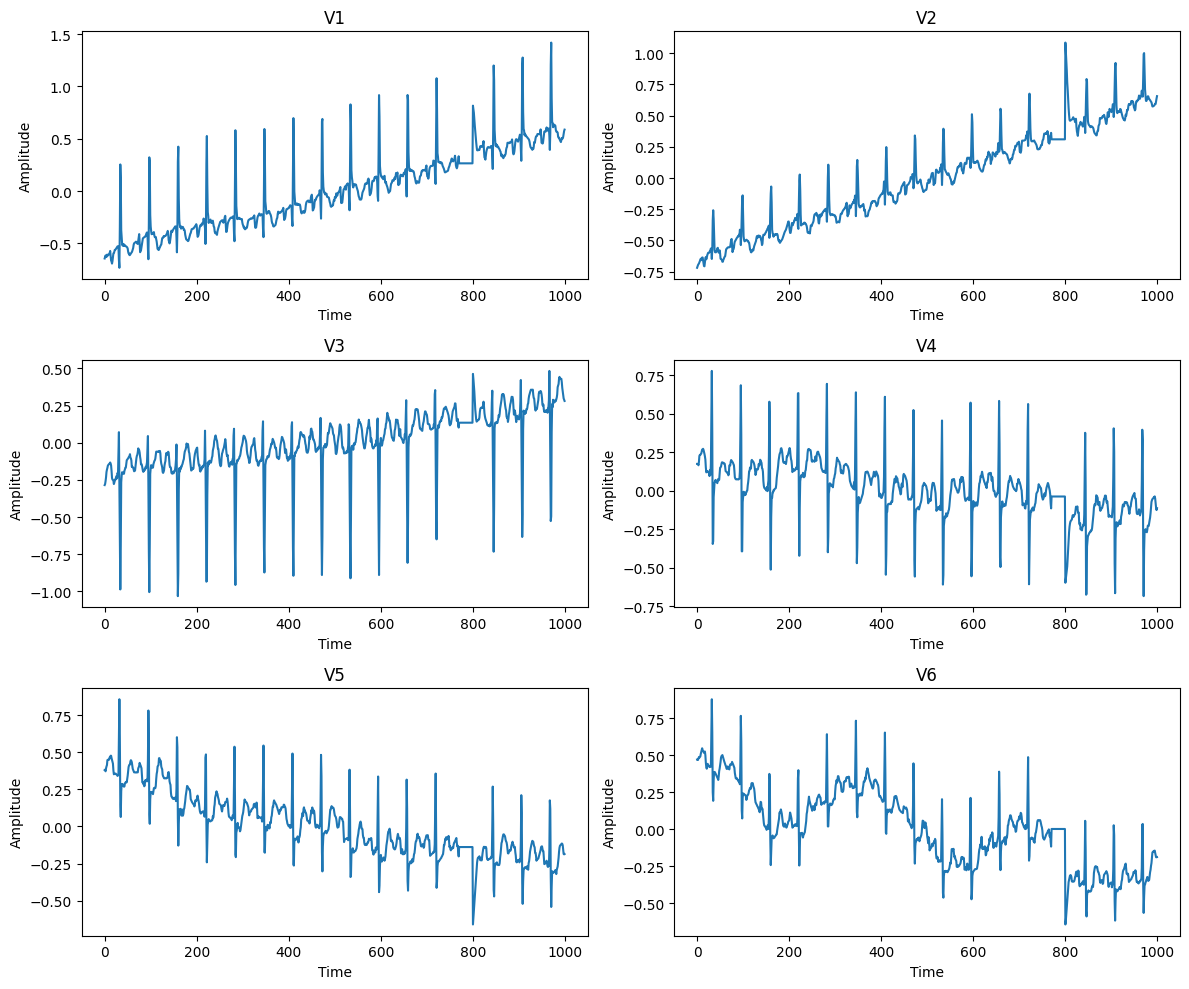

In [27]:
# Lets try remove the artifact at the end of the signal by zeroing it out
signals_corrected = signals.copy()
for i in range(signals_corrected.shape[0]):
    signals_corrected[i][770:800] = np.mean(signals_corrected[i][700:770])
plot_signals(signals_corrected, time_cutoff=1000)

In [28]:
# Lets try to predict again with the corrected signals
signals_corrected_torch = torch.from_numpy(signals_corrected.reshape(1, 6, 1000)).float().to('cuda')
print(signals_corrected_torch.shape)
with torch.no_grad():
    _, these_logits = model(signals_corrected_torch)

# Convert logits to probabilities
probs = torch.nn.functional.softmax(these_logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs)

# Display the predicted lead
pred = np.argmax(these_logits.cpu().numpy(), axis=2)
print(pred)

torch.Size([1, 6, 1000])
[[[ 0.02  0.07  0.03  1.39 95.77  2.72]
  [ 0.53  0.41  0.19  0.27  0.52 98.08]
  [99.17  0.8   0.    0.    0.01  0.02]
  [ 0.22 61.44 37.97  0.09  0.14  0.15]
  [ 0.4   9.89 73.69 13.82  1.64  0.56]
  [ 0.98 10.52 20.18 56.35  8.77  3.2 ]]]
[[4 5 0 1 2 3]]


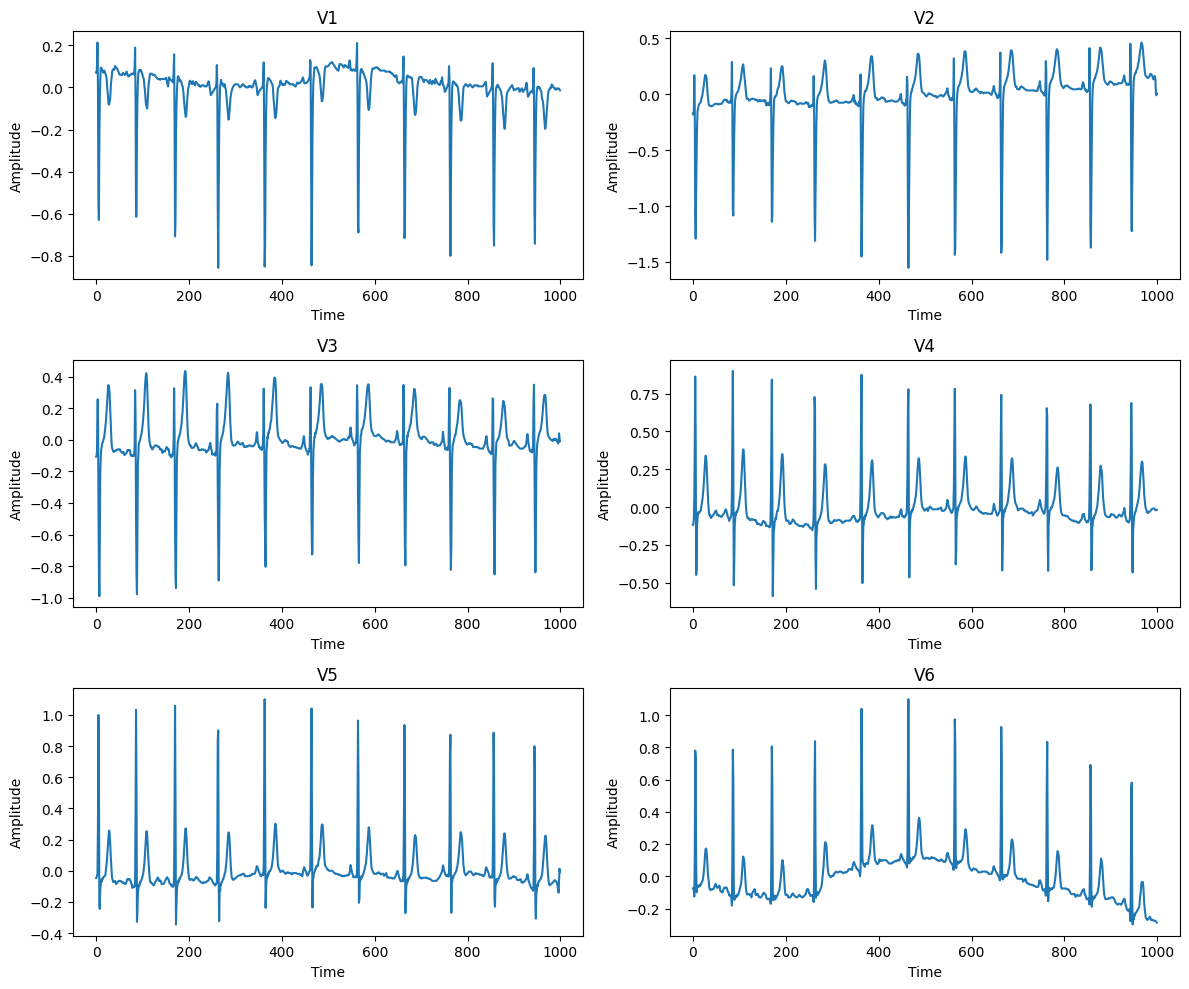

In [29]:
# lets do the same visualization for the first correct sample
signals = val_data[correct[1]].cpu().numpy()

plot_signals(signals, time_cutoff=1000)

The above uses a model that was not trained on preprocessed data. I will now evaluate a model that was trained on data with a highpass filter to remove baseline wander.

In [2]:
# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact("nateml-maastricht-university/bachelors-thesis/04_sigloc12_weight_decay_augment_True_best:v18")
artifact_path = artifact.download()

run = api.run("nateml-maastricht-university/bachelors-thesis/gmzc3d21")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


In [3]:
# Load the model
checkpoint = torch.load(artifact_path + "/04_sigloc12_weight_decay_augment_True_best.pth", map_location=torch.device('cuda'))

# Cast the model to the correct type
model = SigLoc12(cfg.model)
model.to("cuda")
model.load_state_dict(checkpoint)
model.eval()

SigLoc12(
  (local_encoder): LocalEncoder(
    (encoder): Sequential(
      (0): Conv1d(1, 16, kernel_size=(12,), stride=(1,), padding=(3,))
      (1): ReLU()
      (2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(1,))
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): ReLU()
      (8): AdaptiveAvgPool1d(output_size=1)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=128, out_features=64, bias=True)
      (11): ReLU()
    )
  )
  (context_encoder): DeepSetsContextEncoder(
    (phi): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
    )
    (rho): Sequential(
      (0): Linear(in_features=64, out_features=64, bias

In [20]:
# Load the validation data
val_data = np.load('../../data/processed/ptbxl100all/val.npy')
meta = pd.read_csv('../../data/processed/ptbxl100all/meta_val.csv')

print(val_data.shape)
print(meta.shape)

(2183, 1000, 6)
(2183, 30)


In [5]:
from bachelors_thesis.registries.preprocessor_registry import get_preprocessor

def apply_preprocessors(data, sampling_rate, preprocessors: list):
    data_filtered = data.copy()
    for prep_param in preprocessors:
        prep = get_preprocessor(prep_param._preprocessor_)
        data_filtered = prep(data_filtered, sampling_rate=sampling_rate, **prep_param)
    return data_filtered

In [37]:
# Apply filter(s) to the signals
val_data_filtered = apply_preprocessors(val_data, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)

In [38]:
# Convert to tensor
val_data_filtered = torch.from_numpy(val_data_filtered).float()

# Reshape to (_, 6, 1000)
val_data_filtered = val_data_filtered.permute(0, 2, 1)
print(val_data_filtered.shape)

torch.Size([2183, 6, 1000])


In [39]:
# Create a dataloader for the validation data
dataset = SigLocDataset(val_data_filtered)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [40]:
model.eval()
logits = np.zeros((len(dataset), 6, 6))
for idx, batch in enumerate(dataloader):
    # Move the batch to the GPU
    batch = batch.to('cuda')

    if idx == 0:
        print(batch.shape)
    
    # Make predictions
    with torch.no_grad():
        _, these_logits = model(batch)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()

logits.shape

torch.Size([64, 6, 1000])


(2183, 6, 6)

In [41]:
targets = torch.arange(6, device=logits[0].device).expand(2183, -1)

# Convert logits to tensor
logits = torch.from_numpy(logits).float()

# convert logits to probabilities
probs = torch.nn.functional.softmax(logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs[0])

preds = np.argmax(logits.cpu().numpy(), axis=2)

# Accuracy
lead_acc = lead_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
set_acc = set_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

[[99.83  0.16  0.01  0.    0.    0.  ]
 [ 0.07 99.63  0.29  0.01  0.    0.  ]
 [ 0.    0.08 99.88  0.04  0.    0.  ]
 [ 0.    0.01  0.01 99.81  0.16  0.02]
 [ 0.    0.01  0.    0.04 99.86  0.09]
 [ 0.    0.01  0.    0.    0.14 99.85]]
Set level accuracy: 0.8694
Lead level accuracy: 0.9562


In [42]:
# Let's try use the hungarian algorithm to optimize the set level accuracy
from scipy.optimize import linear_sum_assignment

def hungarian_predictions(logits):
    if logits.ndim == 2:
        logits = logits[np.newaxis, :, :]
    elif logits.ndim != 3:
        raise ValueError("Logits must be 2D or 3D array")

    if isinstance(logits, torch.Tensor):
        logits = logits.cpu().numpy()

    B, N, C = logits.shape

    predictions = np.zeros((B, N), dtype=np.int64)

    for b in range(logits.shape[0]):
        # Compute the optimal assignment of signals to leads
        # Effectively we are choosing a one to one assignment of 
        # signals to classes which maximizes the confidence of the model
        # row_ind is the indices of the signals
        # col_ind is the corresponding indices of the targets
        # so, (row_ind[i], col_ind[i]) is the assignment of signal i to class col_ind[i]
        # since logits is square, row_ind corresponds to np.arange(N) (e.g. [0, 1, 2, 3, 4, 5])
        # ideally col_ind should be the same as targets (i.e. [0, 1, 2, 3, 4, 5] as well)
        row_ind, col_ind = linear_sum_assignment(logits[b], maximize=True)

        # Assign the predicted class to the corresponding signal
        predictions[b, row_ind] = col_ind

    return predictions

In [43]:
# Lets try the hungarian algorithm on the logits
hungarian_preds = hungarian_predictions(logits)
print(hungarian_preds.shape)
print(hungarian_preds[2])

(2183, 6)
[0 1 2 3 4 5]


In [44]:
# Now lets calculate the accuracy again using the new
# predictions
hungarian_set_acc = set_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
hungarian_lead_acc = lead_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
print(f"Hungarian Set level accuracy: {hungarian_set_acc:.4f}")
print(f"Hungarian Lead level accuracy: {hungarian_lead_acc:.4f}")

Hungarian Set level accuracy: 0.9143
Hungarian Lead level accuracy: 0.9606


In [180]:
hungarian_preds.shape

(2183, 6)

In [181]:
targets.shape

torch.Size([2183, 6])

In [275]:
mistake_mask = hungarian_preds != targets.cpu().numpy()
mistake_counts = mistake_mask.sum(axis=1)
wrongness_thresh = 6
wrong_hungarian = np.where(mistake_counts >= wrongness_thresh)[0]
len(wrong_hungarian)

9

In [276]:
wrong_hungarian

array([  36,  483,  837,  883, 1215, 1299, 1427, 1753, 1911])

In [277]:
for idx in wrong_hungarian:
    print(hungarian_preds[idx])

[4 3 1 2 5 0]
[1 2 3 4 5 0]
[5 4 3 2 1 0]
[1 3 0 2 5 4]
[5 4 3 1 2 0]
[1 2 3 5 0 4]
[5 0 1 2 3 4]
[1 2 3 4 5 0]
[5 2 1 0 3 4]


pacemaker ekg
{'PACE': 100.0}


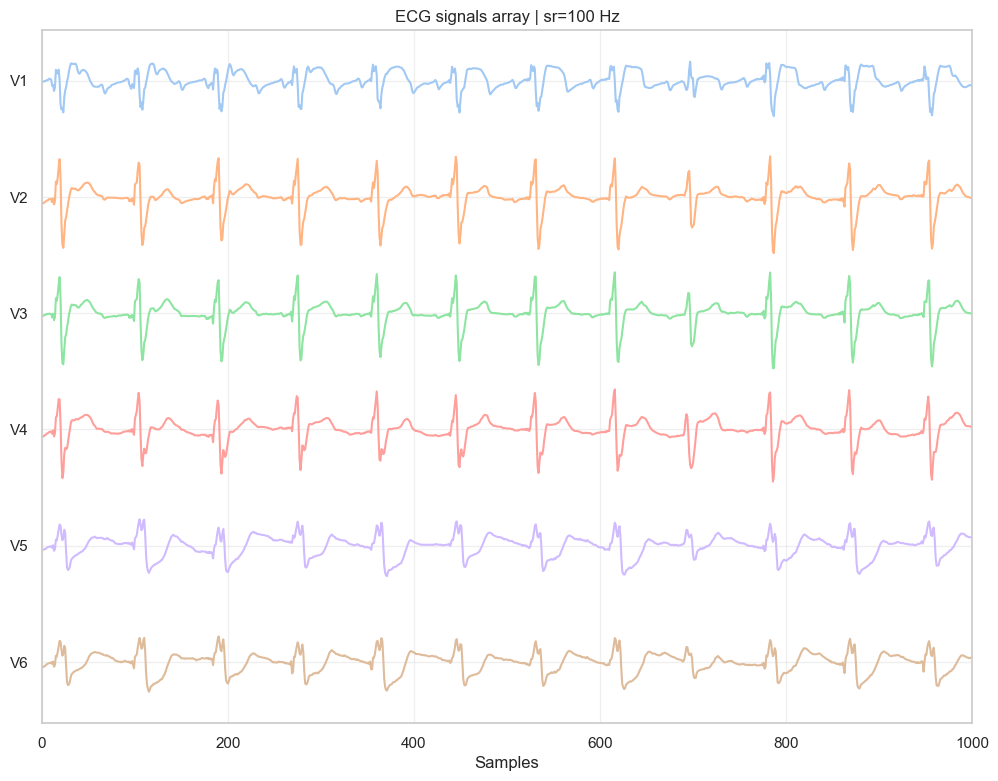

In [278]:
# Lets plot these
idx = wrong_hungarian[0]
signals = val_data_filtered[idx].cpu().numpy()
plot_ecg(signals, sampling_rate=100)
print(meta.iloc[idx].report)
print(meta.iloc[idx].scp_codes)

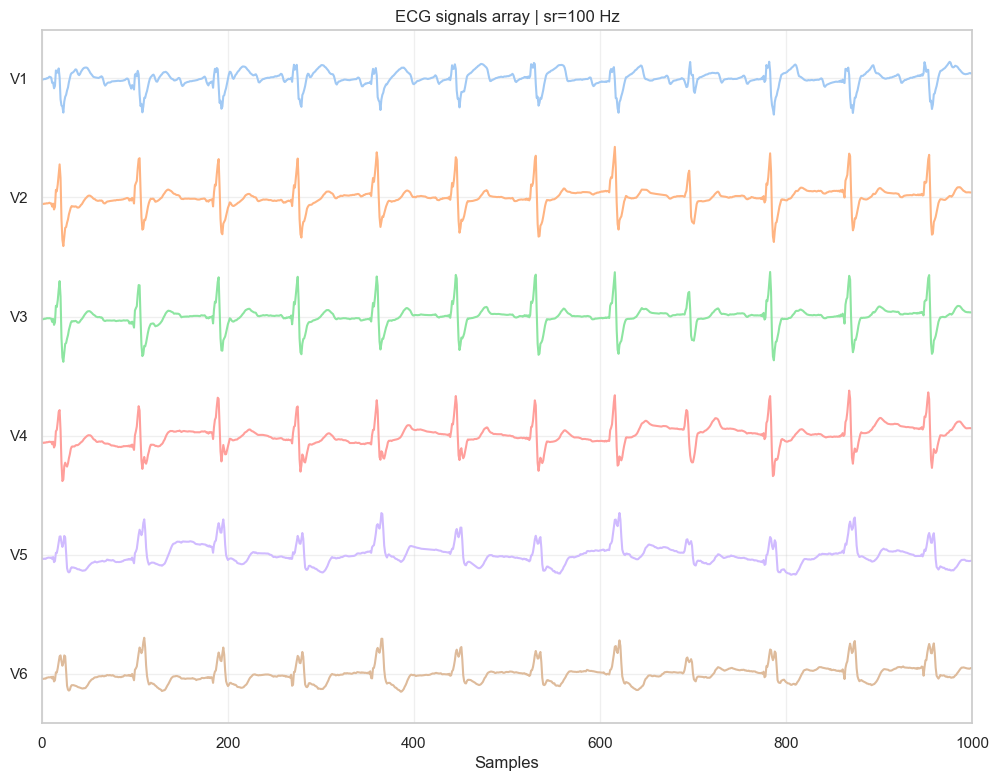

In [279]:
# make sure the metadata corresponds to the signals
ref_sig, leads = get_ecg_signals_from_file(meta.iloc[idx].filename_lr)
# Apply the same preprocessing to the reference signal
# ref_sig = apply_preprocessors(ref_sig, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)
plot_ecg(ref_sig, sampling_rate=100, leads=leads)

In [280]:
meta.iloc[idx].ecg_id

np.int64(190)

In [281]:
# Lets inspect the metadata for these samples
pd.set_option('display.max_columns', None)
meta.iloc[wrong_hungarian]

,Unnamed: 0,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass,present_codes
36,182,190,10782.0,66.0,1,NaN,NaN,NaN,3.0,AT-6 C,1986-03-21 14:53:40,pacemaker ekg,{'PACE': 100.0},NaN,NaN,NaN,NaN,False,False,True,NaN,", alles,",NaN,NaN,NaN,"ja, pacemaker",9,records100/00000/00190_lr,records500/00000/00190_hr,[],{PACE}
483,3873,3893,17201.0,76.0,1,NaN,NaN,NaN,3.0,AT-6 C,1990-03-14 07:54:45,pacemaker ekg,{'PACE': 100.0},NaN,NaN,NaN,NaN,False,False,True,NaN,", alles,",NaN,NaN,NaN,"ja, pacemaker",9,records100/03000/03893_lr,records500/03000/03893_hr,[],{PACE}
837,7275,7296,16637.0,71.0,0,NaN,NaN,1.0,2.0,CS-12,1991-11-12 15:03:57,supraventrikulÄre tachykardie a-v block i p-si...,{'CLBBB': 100.0},LAD,NaN,NaN,1.0,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/07000/07296_lr,records500/07000/07296_hr,['CD'],{CLBBB}
883,7842,7866,20484.0,83.0,1,NaN,NaN,NaN,3.0,AT-6 C,1992-03-14 11:39:12,pacemaker ekg pacemaker kontrol testfrekvens:9...,{'PACE': 100.0},NaN,NaN,NaN,5.0,False,False,True,NaN,NaN,NaN,NaN,NaN,"ja, pacemaker",9,records100/07000/07866_lr,records500/07000/07866_hr,[],{PACE}
1215,10955,10982,4295.0,73.0,0,178.0,90.0,11.0,1.0,AT-6 C 5.5,1993-09-10 14:12:21,sinus rhythm. grossly prolonged pr interval. r...,"{'IMI': 80.0, 'PMI': 50.0, 'CRBBB': 100.0, 'LA...",NaN,Stadium III,NaN,0.0,False,False,True,NaN,", mittel,",NaN,NaN,NaN,NaN,9,records100/10000/10982_lr,records500/10000/10982_hr,"['MI', 'MI', 'CD', 'CD', 'CD']","{IMI, PMI, CRBBB, LAFB, 1AVB}"
1299,11857,11889,19458.0,55.0,0,NaN,NaN,NaN,3.0,AT-6 C,1994-03-05 12:51:45,sinusrytm vÄnstersidigt skÄnkelblock,"{'WPW': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/11000/11889_lr,records500/11000/11889_hr,['CD'],{WPW}
1427,13037,13069,12204.0,300.0,1,NaN,NaN,1.0,2.0,CS-12,1994-09-28 10:37:54,vorhofflimmern/-flattern schwierig bestimmbare...,"{'ASMI': 15.0, 'CRBBB': 100.0, 'LPFB': 100.0, ...",NaN,unknown,NaN,1.0,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/13000/13069_lr,records500/13000/13069_hr,"['MI', 'CD', 'CD']","{CRBBB, LPFB, ASMI}"
1753,16407,16445,19238.0,300.0,1,NaN,NaN,1.0,2.0,CS-12,1996-07-20 07:05:48,schrittmacher ekg,{'PACE': 100.0},NaN,NaN,NaN,1.0,False,False,True,NaN,", I-AVR,",NaN,NaN,1ES,"ja, pacemaker",9,records100/16000/16445_lr,records500/16000/16445_hr,[],{PACE}
1911,18211,18250,1872.0,81.0,0,165.0,75.0,3.0,1.0,AT-6 C 5.5,1997-07-27 12:24:47,atrial fibrillation. premature ventricular con...,"{'ASMI': 80.0, 'ALMI': 80.0, 'IVCD': 100.0, 'Q...",NaN,Stadium III,NaN,0.0,False,False,True,NaN,NaN,NaN,NaN,1ES,NaN,9,records100/18000/18250_lr,records500/18000/18250_hr,"['MI', 'MI', 'CD']","{IVCD, ALMI, ASMI}"


In [282]:
# Convert scp code strings to dictionaries
import ast
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

ValueError: malformed node or string: {'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}

In [283]:
THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(codes_above_threshold)

In [284]:
from collections import Counter
distribution: Counter = Counter(code
                       for codes in meta["present_codes"]
                       for code in codes)

code_densities = distribution

# Get the code counts of just the outliers
outlier_distribution = Counter(code
                       for codes in meta.iloc[wrong_hungarian]["present_codes"]
                       for code in codes)

outlier_code_densities = outlier_distribution

In [285]:
# Create dictionary mapping scp codes to their descriptions
scp_statements = pd.read_csv('../../data/raw/ptb-xl/scp_statements.csv', index_col=0)

In [ ]:
def pretty_code_density_plot(code_densities          : Counter,
                             miscl_code_densities    : Counter,
                             n                       : int  = 12,
                             relative                : bool = True,
                             scp_statement_csv       : str | Path = "scp_statements.csv",
                             bar_thickness           : float = 0.45,
                             colours                 : tuple = ("#4C9BE8", "#F5A873")):
    """
    Horizontal grouped bar‑chart that compares the *n* most common
    mis‑classified SCP codes with their distribution in the full dataset.
    Bars are labelled by **code**; a description table sits underneath.
    -----------------------------------------------------------------------
    Parameters
    ----------
    code_densities        : Counter   – counts for the whole dataset
    miscl_code_densities  : Counter   – counts for the mis‑classified set
    n                     : int       – how many top mis‑classified codes
    relative              : bool      – plot frequencies (%) instead of raw counts
    scp_statement_csv     : str|Path  – maps Code → Description (PTB‑XL file)
    bar_thickness         : float     – vertical size of each bar
    colours               : tuple     – colours for the two groups
    """
    # ------------------------------------------------------------------ #
    # 1. Data wrangling                                                  #
    # ------------------------------------------------------------------ #
    top_codes = [c for c, _ in miscl_code_densities.most_common(n)]

    df = pd.DataFrame({
        "Misclassified" : [miscl_code_densities[c] for c in top_codes],
        "All records"   : [code_densities.get(c, 0) for c in top_codes],
    }, index=top_codes)

    if relative:
        df["Misclassified"] /= len(wrong_hungarian)
        df["All records"]   /= len(meta)

    # pull human‑readable descriptions
    if Path(scp_statement_csv).exists():
        stmt = pd.read_csv(scp_statement_csv, index_col=0)["description"]
        descs = stmt.reindex(df.index).fillna("(n/a)")
    else:
        descs = pd.Series("(unknown)", index=df.index)

    # ------------------------------------------------------------------ #
    # 2. Plot                                                            #
    # ------------------------------------------------------------------ #
    fig = plt.figure(figsize=(11, 8), constrained_layout=True)
    gs  = fig.add_gridspec(2, 1, height_ratios=[4, 1.4], hspace=0.05)

    # --- a) horizontal bars ------------------------------------------ #
    ax = fig.add_subplot(gs[0])

    y = np.arange(len(df))
    ax.barh(y - bar_thickness/2, df["Misclassified"],
            height=bar_thickness, color=colours[0])
    ax.barh(y + bar_thickness/2, df["All records"],
            height=bar_thickness, color=colours[1])

    ax.set_yticks(y)
    ax.set_yticklabels(df.index)          # <- **SCP codes here**
    ax.invert_yaxis()
    ax.set_xlabel("Relative frequency" if relative else "Count")
    ax.set_title(f"Relative Frequency of SCP codes in misclassified ECGs vs. all ECGs (Top {n} codes)")

    fig.legend(labels=["Misclassified", "All records"],
               loc="center right",
               bbox_to_anchor=(0.93, 0.5),
               frameon=False)

    # some breathing room on the left so codes don't get clipped
    # plt.subplots_adjust(left=0.28)

    # --- b) description table ---------------------------------------- #
    tb_ax = fig.add_subplot(gs[1])
    tb_ax.axis("off")                     # table only, no axes
    tb_ax.set_title("SCP code descriptions", fontweight="bold", pad=42)

    cell_text = [[c, d] for c, d in zip(df.index, descs)]
    table = tb_ax.table(cellText=cell_text,
                        colLabels=["Code", "Description"],
                        loc="center",
                        cellLoc="left",
                        colLoc="left")
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.2)                   # row‑height tweak

    plt.show()

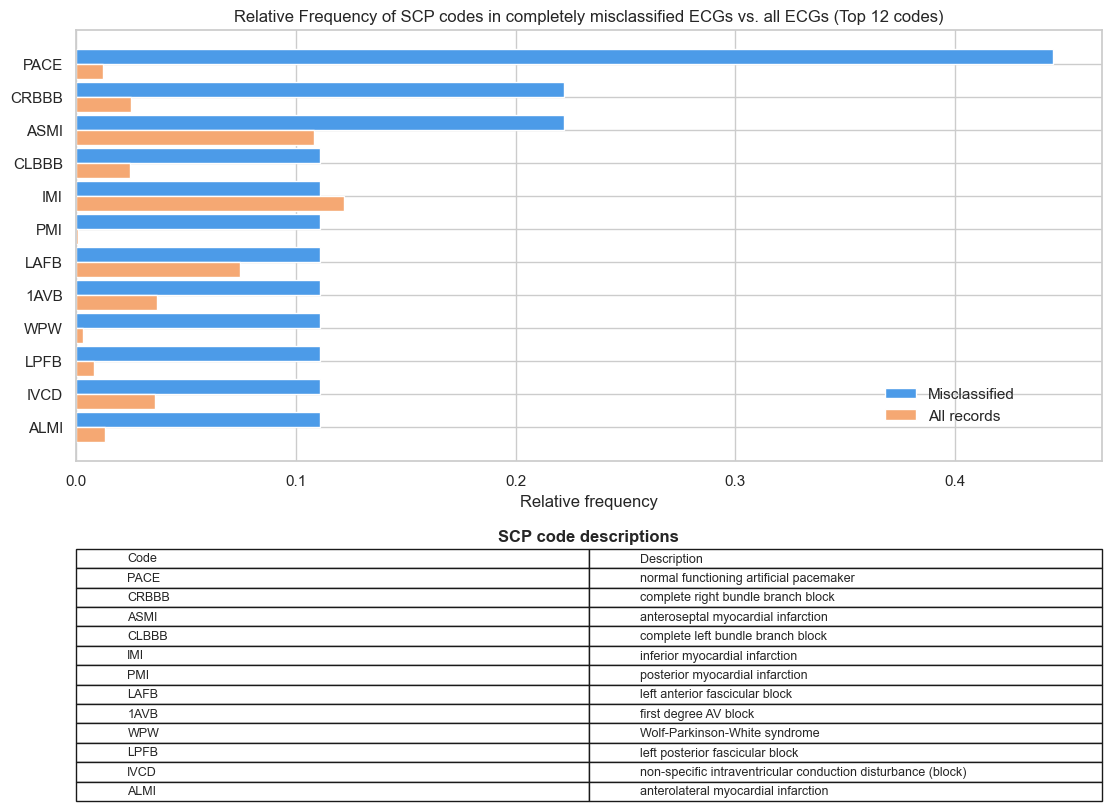

In [288]:
pretty_code_density_plot(
    code_densities,
    outlier_code_densities,
    scp_statement_csv="../../data/raw/ptb-xl/scp_statements.csv",
)

In [ ]:
# Sort codes by discrepency between the two distributions

['NORM', 'IMI', 'ASMI', 'LVH', 'NDT', 'LAFB', 'ISC_', 'IRBBB', 'PVC', '1AVB']

In [234]:
# Lets take a look at how pacemakers affect the ECG signal

# Filter samples that contain pacemakers
pacemaker_idx = np.where(meta["scp_codes"].apply(lambda x: "PACE" in x.keys()))[0]
print(len(pacemaker_idx))

29


In [235]:
# Calculate accuracy on pacemaker samples
pacemaker_acc = set_level_accuracy(predictions=hungarian_preds[pacemaker_idx])
pacemaker_acc

np.float64(0.3793103448275862)

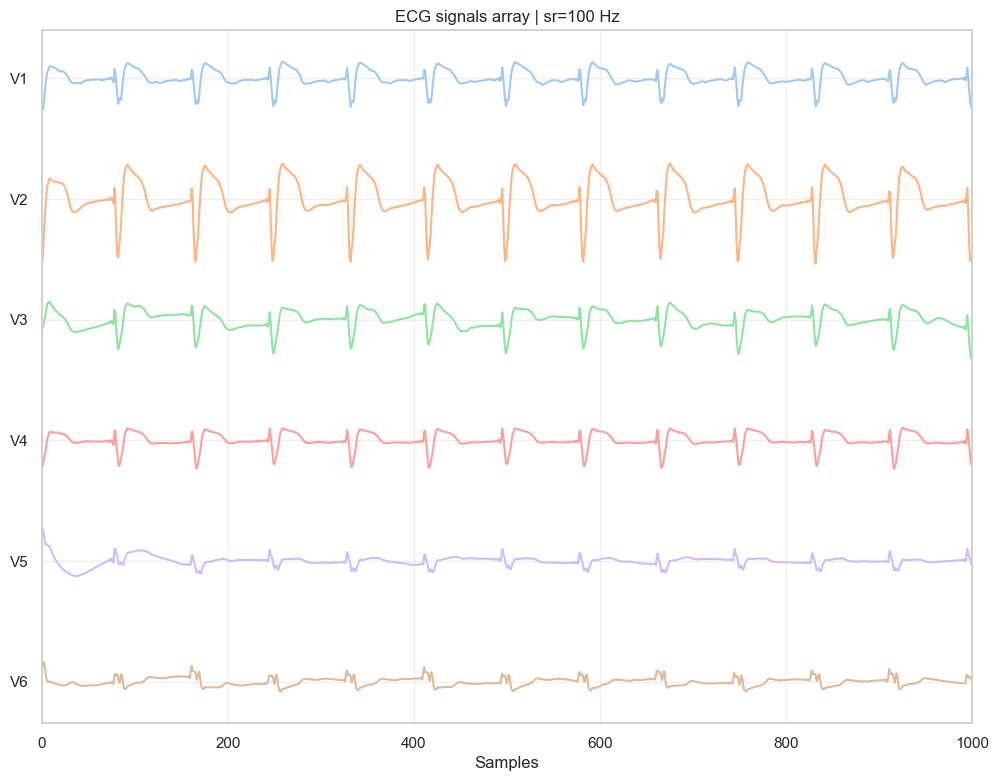

In [207]:
# Lets take a peek at what the signals look like for the pacemaker samples
signals = val_data_filtered[pacemaker_idx].cpu().numpy()
plot_ecg(signals[5], sampling_rate=100)

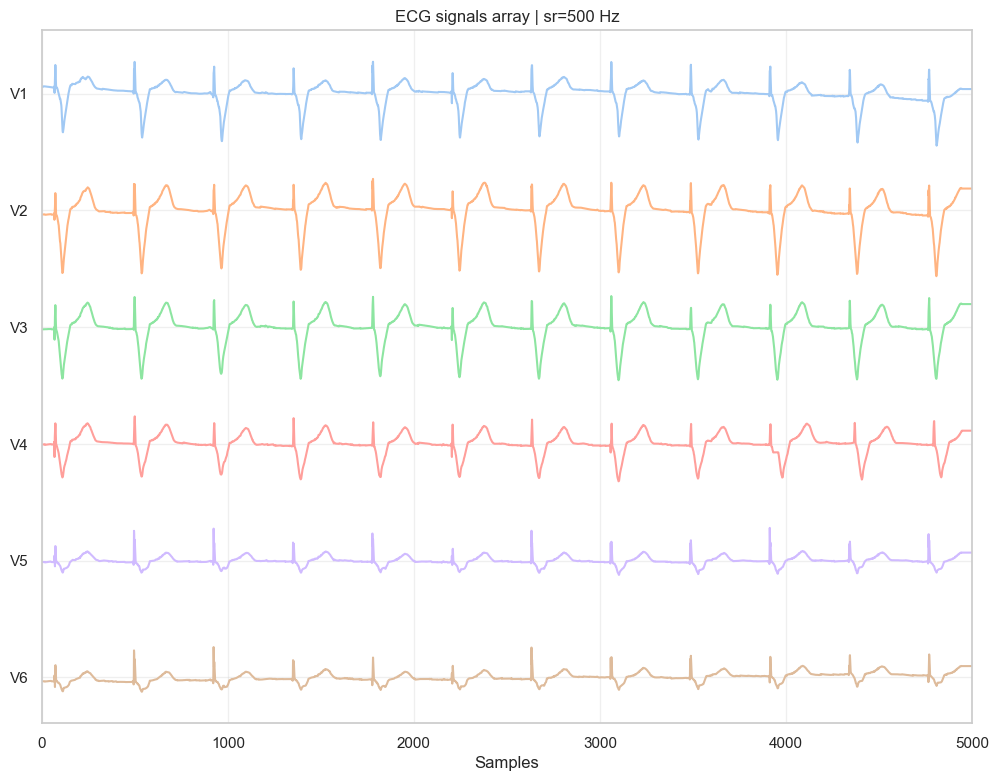

In [219]:
# Lets look at the 500hz sample from ptb-xl
filename = meta.iloc[pacemaker_idx[7]].filename_hr
signals, leads = get_ecg_signals_from_file(filename, only_precordial_leads=True)
plot_ecg(signals, sampling_rate=500, leads=leads)

In [218]:
meta.iloc[pacemaker_idx[7]]

Unnamed: 0                                           3873
ecg_id                                               3893
patient_id                                        17201.0
age                                                  76.0
sex                                                     1
height                                                NaN
weight                                                NaN
nurse                                                 NaN
site                                                  3.0
device                                             AT-6 C
recording_date                        1990-03-14 07:54:45
report                                      pacemaker ekg
scp_codes                                 {'PACE': 100.0}
heart_axis                                            NaN
infarction_stadium1                                   NaN
infarction_stadium2                                   NaN
validated_by                                          NaN
second_opinion

[0.98350893 0.94457169 0.94594595 0.94090701 0.95464956 0.96747595]


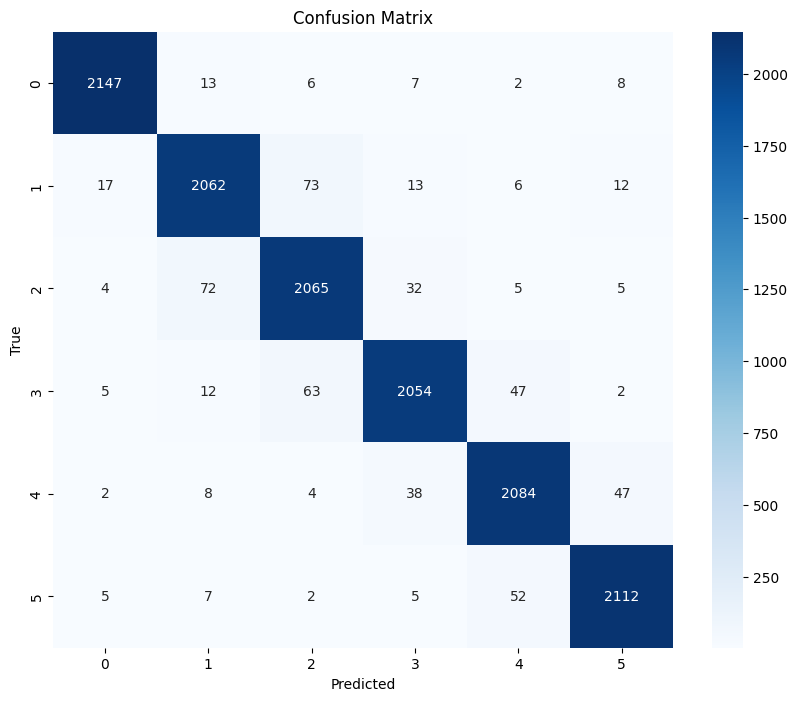

In [44]:
# Lets compute the per electrode accuracy
# preds is of shape (2183, 6)
# targets is of shape (2183, 6)
# We want to compute the accuracy for each lead separately
lead_acc = np.zeros((6,))
for i in range(6):
    lead_acc[i] = np.mean(preds[:, i] == targets[:, i].cpu().numpy())
print(lead_acc)

def confusion_matrix(preds, targets, num_classes=6):
    # preds is of shape (2183, 6)
    # targets is of shape (2183, 6)

    cm = np.zeros((num_classes, num_classes))
    for i in range(len(preds)):
        cm[targets[i], preds[i]] += 1

    cm = np.nan_to_num(cm)
    return cm

cm = confusion_matrix(preds, targets.cpu().numpy())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [45]:
print(preds.shape)
print(preds.shape)

(2183, 6)
(2183, 6)


In [46]:
# Find outliers

# These are samples where the model predicted all 6 classes wrong 
outliers = np.where(np.all(preds != targets.cpu().numpy(), axis=1))[0]
print(outliers)
print(preds[outliers])
print(len(outliers))

# print("Probabilities:")
# print(probs[outliers])

# These are samples where the model predicted all 6 classes right
correct = np.where(np.all(preds == targets.cpu().numpy(), axis=1))[0]

[1215 1753 1911 2100]
[[5 4 3 1 1 1]
 [3 2 4 4 5 0]
 [5 2 1 1 3 4]
 [2 2 0 4 5 4]]
4


Signal 1215


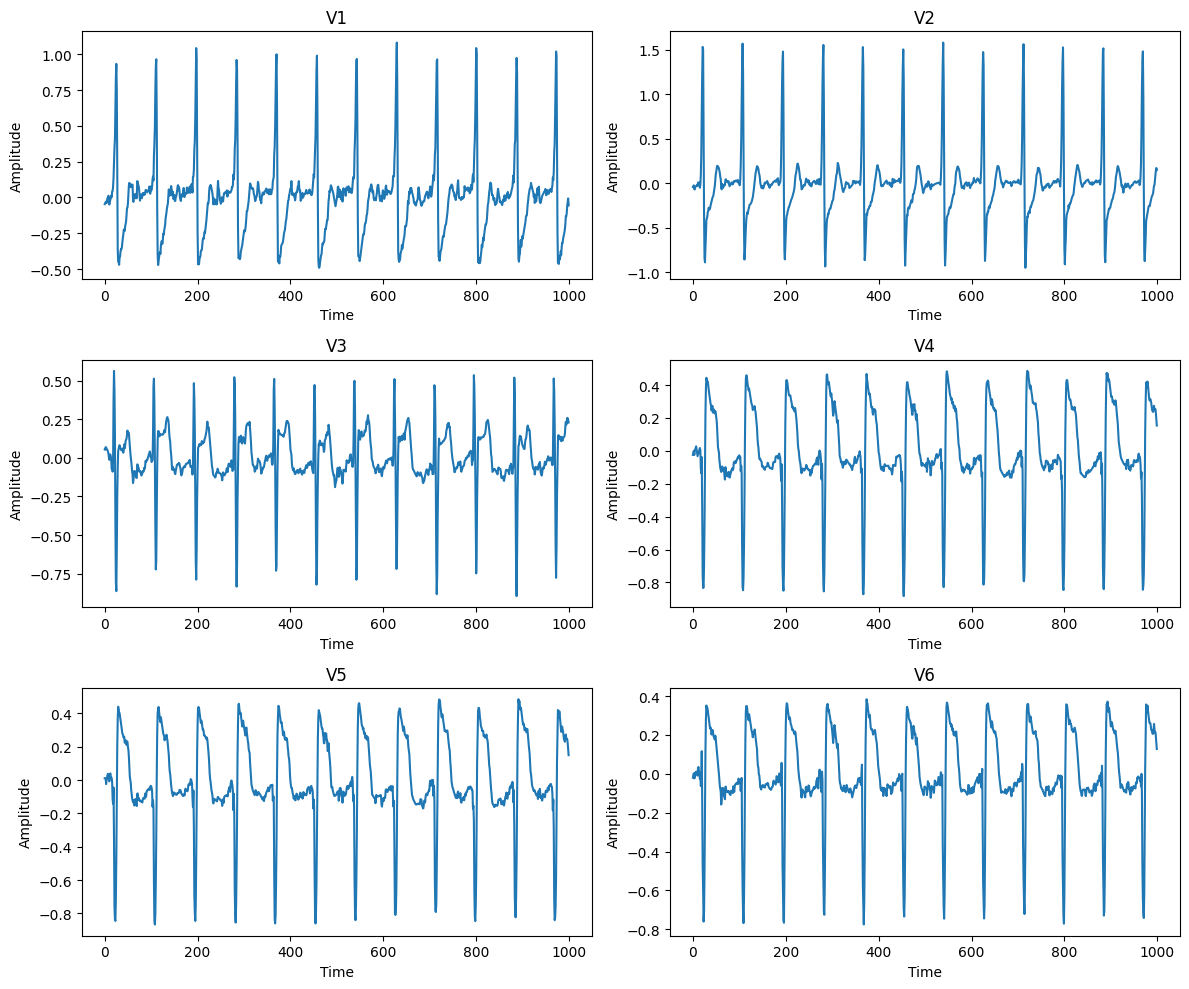

Predictions:
[5 4 3 1 1 1]
Prediction Probabilities:
[[ 0.04  0.    0.    0.13  0.51 99.32]
 [ 0.06  0.02  0.04  0.08 98.89  0.91]
 [ 0.01  0.01  0.04 99.67  0.25  0.01]
 [ 5.37 60.94 33.55  0.14  0.    0.  ]
 [ 3.99 51.7  44.17  0.14  0.    0.  ]
 [39.8  40.12 19.81  0.27  0.    0.  ]]


In [47]:
# lets take a look at the signals from one of the outliers

idx = outliers[0]
print(f"Signal {idx}")
signals = val_data_filtered[idx]
plot_signals(signals, time_cutoff=1000)
print("Predictions:")
print(preds[idx])
print("Prediction Probabilities:")
print(probs[idx])

In [48]:
# I want to find all cases where the model predicted a lead more than 2 "positions" away from the correct lead
# E.g. if the model predicted 0, but the correct lead was 3, this is a distance of 3
wrongness_thresh = 4
wrong = np.where(np.abs(preds - targets.cpu().numpy()) > wrongness_thresh)[0]
print(len(wrong))
print(preds[wrong])

13
[[0 3 3 2 5 0]
 [5 1 2 2 1 4]
 [5 4 2 2 1 0]
 [5 4 2 2 1 0]
 [5 1 1 3 5 5]
 [5 2 2 2 5 0]
 [5 2 2 2 5 0]
 [5 4 3 1 1 1]
 [5 0 2 4 1 0]
 [5 0 2 4 1 0]
 [3 2 4 4 5 0]
 [5 2 1 1 3 4]
 [5 0 2 2 3 5]]


Signal 304


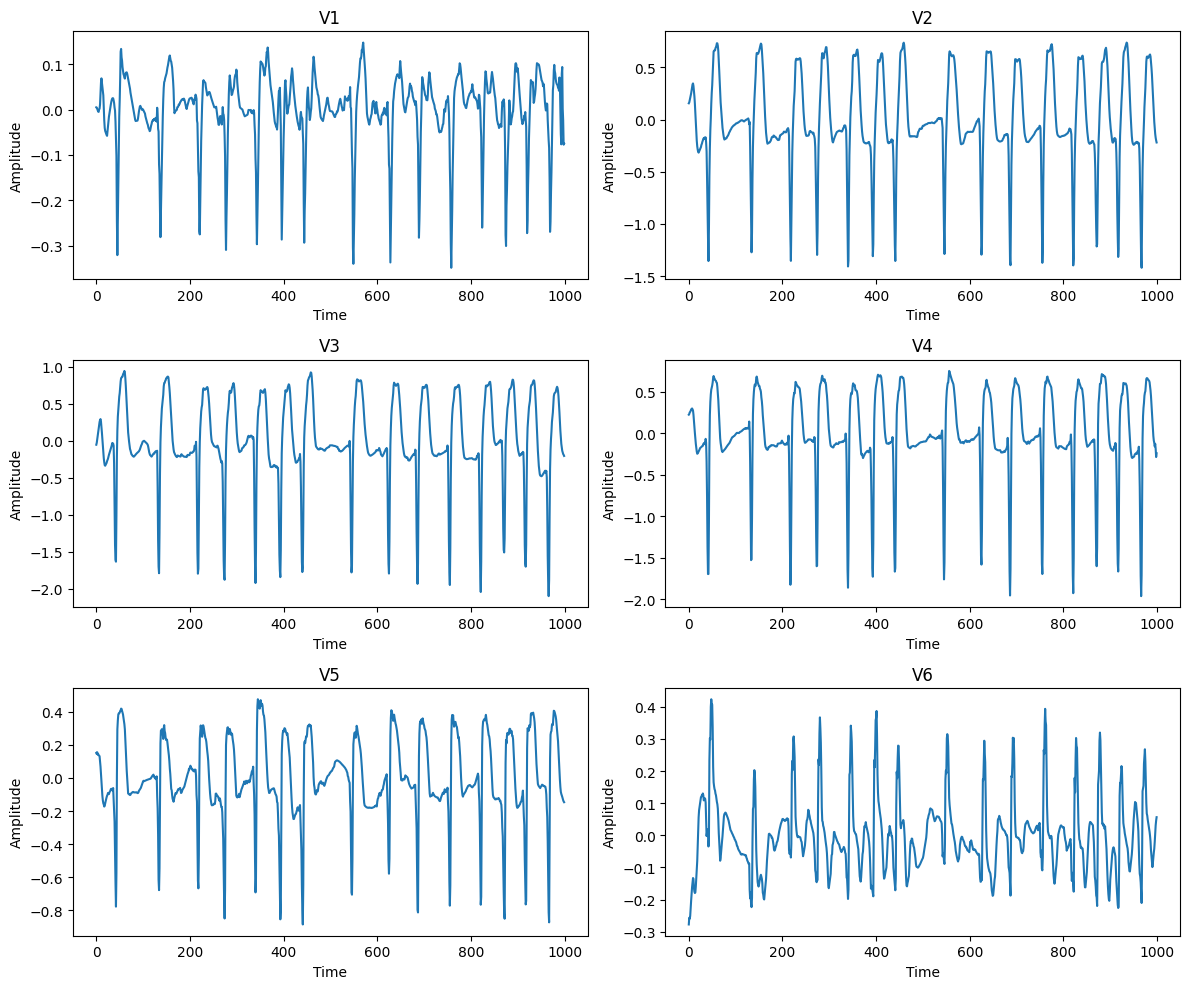

Predictions:
[5 1 2 2 1 4]
Prediction Probabilities:
[[ 0.2   0.44  0.02  0.01  0.73 98.6 ]
 [ 2.61 70.9  12.24 13.77  0.45  0.03]
 [ 3.69 23.95 43.03 25.84  3.29  0.19]
 [ 0.8  42.72 47.61  8.47  0.36  0.04]
 [ 2.36 38.46 24.6  33.17  1.32  0.08]
 [ 6.81  0.22  0.01  0.03 92.75  0.18]]


In [49]:
# Lets inspect these very wrong predictions
idx = wrong[1]
print(f"Signal {idx}")
signals = val_data_filtered[idx]
plot_signals(signals, time_cutoff=1000)
print("Predictions:")
print(preds[idx])
print("Prediction Probabilities:")
print(probs[idx])

I am now going to see how the model performs when being validated on a set of only "normal" heartbeats.

In [18]:
val_data_norm = np.load('../../data/processed/ptbxl100norm/val.npy')
print(val_data_norm.shape)

(955, 1000, 6)


In [19]:
# Preprocess the data
val_data_norm = apply_preprocessors(val_data_norm, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)

In [20]:
# Convert to tensor
val_data_norm = torch.from_numpy(val_data_norm).float()
val_data_norm = val_data_norm.permute(0, 2, 1)
print(val_data_norm.shape)

torch.Size([955, 6, 1000])


In [21]:
# Create a dataloader for the validation data
dataset_norm = SigLocDataset(val_data_norm)
batch_size = 64
dataloader_norm = DataLoader(dataset_norm, batch_size=batch_size, shuffle=False)

In [26]:
model.eval()
logits = np.zeros((len(dataset_norm), 6, 6))
cursor = 0

for batch in dataloader_norm:
    batch = batch.to('cuda')

    with torch.no_grad():
        _, these_logits = model(batch)
        b = these_logits.shape[0]

        logits[cursor:cursor + b] = these_logits.cpu().numpy()
        cursor += b  # advance the write pointer

assert cursor == len(dataset_norm), f"Expected {len(dataset_norm)} samples, got {cursor}"
logits.shape

(955, 6, 6)

In [27]:
targets = torch.arange(6, device=logits[0].device).expand(logits.shape[0], -1)

# Convert logits to tensor
logits = torch.from_numpy(logits).float()

# convert logits to probabilities
probs = torch.nn.functional.softmax(logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs[0])

# Lead-wise accuracy
preds = logits.argmax(dim=2).cpu().numpy()

lead_acc = lead_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
set_acc = set_level_accuracy(logits=logits.cpu().numpy(), targets=targets.cpu().numpy())
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

[[99.83  0.08  0.09  0.    0.    0.  ]
 [ 0.09 99.79  0.12  0.    0.    0.  ]
 [ 0.01  0.04 99.95  0.    0.    0.  ]
 [ 0.    0.    0.   99.87  0.1   0.02]
 [ 0.    0.    0.    0.17 99.61  0.21]
 [ 0.    0.    0.    0.02  0.19 99.79]]
Set level accuracy: 0.9654
Lead level accuracy: 0.9911


In [28]:
hungarian_preds = hungarian_predictions(logits)
hungarian_set_acc = set_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
hungarian_lead_acc = lead_level_accuracy(predictions=hungarian_preds, targets=targets.cpu().numpy())
print(f"Hungarian Set level accuracy: {hungarian_set_acc:.4f}")
print(f"Hungarian Lead level accuracy: {hungarian_lead_acc:.4f}")

Hungarian Set level accuracy: 0.9791
Hungarian Lead level accuracy: 0.9923


In [84]:
# These are samples where the model predicted all 6 classes wrong 
outliers = np.where(np.all(preds != targets.cpu().numpy(), axis=1))[0]
print(outliers)
print(preds[outliers])
print(len(outliers))

[]
[]
0


[0.99895288 0.99267016 0.99162304 0.98324607 0.98848168 0.99162304]


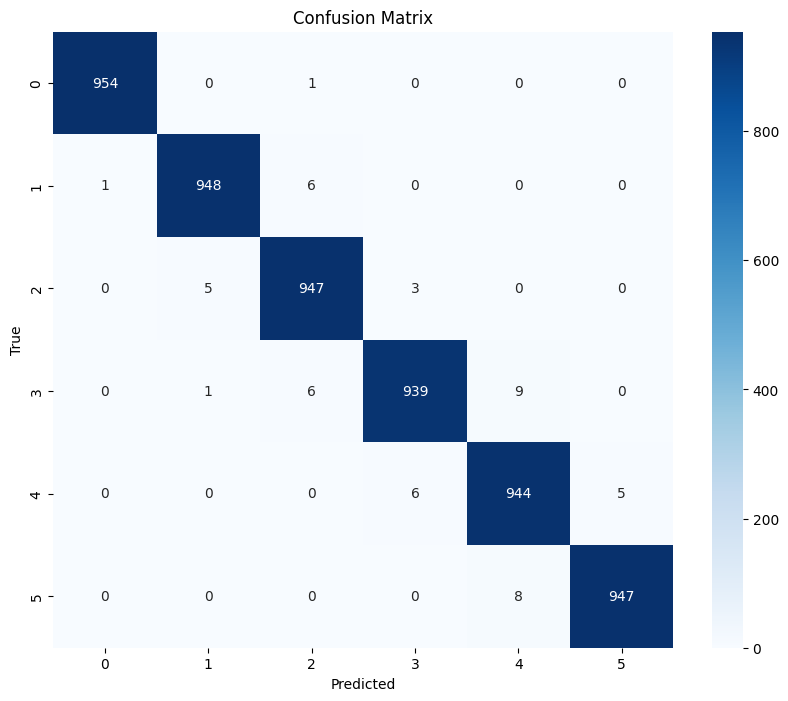

In [85]:
# Lets compute the per electrode accuracy
# preds is of shape (2183, 6)
# targets is of shape (2183, 6)
# We want to compute the accuracy for each lead separately
lead_acc = np.zeros((6,))
for i in range(6):
    lead_acc[i] = np.mean(preds[:, i] == targets[:, i].cpu().numpy())
print(lead_acc)

def confusion_matrix(preds, targets, num_classes=6):
    # preds is of shape (2183, 6)
    # targets is of shape (2183, 6)

    cm = np.zeros((num_classes, num_classes))
    for i in range(len(preds)):
        cm[targets[i], preds[i]] += 1

    cm = np.nan_to_num(cm)
    return cm

cm = confusion_matrix(preds, targets.cpu().numpy())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Now lets load the new model, SigLab, which uses the Hungarian algorithm to assign leads to signals.

In [4]:
# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact("nateml-maastricht-university/bachelors-thesis/05_siglab_baseline_best:best")
artifact_path = artifact.download()

run = api.run("nateml-maastricht-university/bachelors-thesis/yzyhglwb")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


In [5]:
from bachelors_thesis.modeling.siglab import SigLab

# Load the model
checkpoint = torch.load(artifact_path + "/05_siglab_baseline_best.pth", map_location=torch.device('cuda'))

# Cast the model to the correct type
model = SigLab(cfg.model)
model.to("cuda")
model.load_state_dict(checkpoint)
model.eval()

SigLab(
  (local_encoder): LocalEncoder(
    (encoder): Sequential(
      (0): Conv1d(1, 16, kernel_size=(12,), stride=(1,), padding=(3,))
      (1): ReLU()
      (2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(1,))
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): ReLU()
      (8): AdaptiveAvgPool1d(output_size=1)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=128, out_features=64, bias=True)
      (11): ReLU()
    )
  )
  (context_encoder): DeepSetsContextEncoder(
    (phi): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
    )
    (rho): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=T

In [6]:
val_data = np.load('../../data/processed/ptbxl100all/val.npy')
val_data = apply_preprocessors(val_data, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)
val_data = torch.from_numpy(val_data).float()
val_data = val_data.permute(0, 2, 1)
print(val_data.shape)

torch.Size([2183, 6, 1000])


In [7]:
# Create a dataloader for the validation data
dataset = SigLocDataset(val_data)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [11]:
from bachelors_thesis.modeling.siglab import permutation_loss

model.eval()
predictions = np.zeros((len(dataset), 6))
total_loss = 0
for idx, batch in enumerate(dataloader):
    # Move the batch to the GPU
    batch = batch.to('cuda')

    if idx == 0:
        print(batch.shape)
    
    # Make predictions
    with torch.no_grad():
        # these_logits = model(batch)
        logits = model.forward(batch)
        print(logits)
        #these_predictions = model.predict_leads(batch)
        these_predictions = model.predict(logits)
        predictions[(idx * batch_size):(idx * batch_size + batch_size)] = these_predictions
        # logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()

print(predictions.shape)

torch.Size([64, 6, 1000])
tensor([[[   3.4197,  -11.7860,  -23.1987,    3.7429,   -6.7507,  -36.4208],
         [   1.1232,   39.5327,  -71.6256,  -33.7116,  -46.0432,  -79.8393],
         [   6.0989,   -9.5091,  -28.1608,    2.4368,  -10.2143,  -42.0943],
         [ -17.4525,  -34.9408,    0.9053,    0.1157,    9.5977,  -16.2106],
         [ -32.2600,  -51.4994,   10.4716,  -12.1204,    1.5324,   -6.3291],
         [ -50.8779,  -78.6943,    6.1080,  -27.3554,  -11.4436,   19.6012]],

        [[   8.4531,   -5.9075,  -31.1823,    5.5957,  -10.8010,  -46.5122],
         [   5.8961,   -9.3236,  -29.0922,    7.5589,   -8.9198,  -45.1641],
         [  -4.9816,   47.0397,  -74.9199,  -36.0029,  -49.5215,  -84.6645],
         [ -26.9304,  -52.8893,    3.3208,   -1.3328,   18.2649,  -20.2611],
         [ -44.1966,  -71.9590,   16.0005,  -20.6617,   -1.5856,   -4.1268],
         [ -53.5348,  -79.9577,    0.3681,  -31.2053,  -16.7425,   30.8063]],

        [[  -7.8255,   60.0700,  -87.0479,  -4

In [10]:
predictions[0]

array([3., 1., 0., 4., 2., 5.])

In [ ]:
from bachelors_thesis.modeling.siglab import permutation_loss

loss = permutation_loss

In [9]:
predictions

array([[3., 1., 0., 4., 2., 5.],
       [0., 3., 1., 4., 2., 5.],
       [1., 3., 0., 4., 2., 5.],
       ...,
       [1., 0., 3., 4., 2., 5.],
       [1., 0., 3., 4., 2., 5.],
       [1., 0., 3., 4., 2., 5.]])

In [98]:
targets = torch.arange(6, device=logits[0].device).expand(2183, -1)

# Convert logits to tensor
logits = torch.from_numpy(logits).float()

# convert logits to probabilities
probs = torch.nn.functional.softmax(logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs[0])

preds = np.argmax(logits.cpu().numpy(), axis=2)

# Accuracy
lead_acc = lead_level_accuracy(logits.cpu().numpy(), targets.cpu().numpy())
set_acc = set_level_accuracy(logits.cpu().numpy(), targets.cpu().numpy())
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

[[ 41.99   0.     0.    58.01   0.     0.  ]
 [  0.   100.     0.     0.     0.     0.  ]
 [ 97.5    0.     0.     2.5    0.     0.  ]
 [  0.     0.     0.02   0.01  99.98   0.  ]
 [  0.     0.    99.99   0.     0.01   0.  ]
 [  0.     0.     0.     0.     0.   100.  ]]
Set level accuracy: 0.0000
Lead level accuracy: 0.2648
